# Imports

In [0]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

In [0]:
# general array and data handling
import numpy as np
import pandas as pd

# tensor operations and neural networks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, LeakyReLU, Flatten

# Ploting
import matplotlib.pyplot as plt
% matplotlib inline

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

# Data Loading

In [0]:
!git clone https://github.com/grudloff/stock_market_GAN.git

fatal: destination path 'stock_market_GAN' already exists and is not an empty directory.


In [0]:
data_names = ["S&P500","SSE","IBM","MSFT","PAICC"]
data_name = data_names[0]
data_path="stock_market_GAN/datasets/"+data_name+".csv"
print(data_path)
dataframe = pd.read_csv(data_path)

stock_market_GAN/datasets/S&P500.csv


In [0]:
dataframe.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5031.000000,5031.000000,5031.000000,5031.000000,5031.000000,5.031000e+03
mean,1495.419580,1504.207347,1485.896934,1495.566086,1495.566086,2.954812e+09
std,499.462791,499.894439,498.801221,499.378368,499.378368,1.545804e+09
min,679.280029,695.270020,666.789978,676.530029,676.530029,3.121200e+08
25%,1151.739990,1159.934998,1142.179993,1151.629944,1151.629944,1.488865e+09
50%,1334.369995,1343.319946,1325.689941,1334.219971,1334.219971,3.078530e+09
75%,1806.269959,1810.450012,1800.674988,1805.450012,1805.450012,3.886925e+09
max,2936.760010,2940.909912,2927.110107,2930.750000,2930.750000,1.145623e+10


In [0]:
dataframe.shape

(5031, 7)

In [0]:
def add_Ma(dataframe):
  Ma_window=5
  for i in range(0,dataframe.shape[0]-Ma_window):
    dataframe.loc[dataframe.index[i+Ma_window],'Ma'] = np.round(((dataframe.iloc[i,4]+ dataframe.iloc[i+1,4] +dataframe.iloc[i+2,4] + dataframe.iloc[i+3,4]+ dataframe.iloc[i+4,4])/5),6)
  return dataframe[5:-5]

dataframe=add_Ma(dataframe)
dataframe.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ma
5,1999-01-11,1275.089966,1276.219971,1253.339966,1263.880005,1263.880005,818000000,1258.007983
6,1999-01-12,1263.880005,1264.449951,1238.290039,1239.510010,1239.510010,800200000,1265.163989
7,1999-01-13,1239.510010,1247.750000,1205.459961,1234.400024,1234.400024,931500000,1264.109985
8,1999-01-14,1234.400024,1236.810059,1209.540039,1212.189941,1212.189941,797200000,1256.521997
9,1999-01-15,1212.189941,1243.260010,1212.189941,1243.260010,1243.260010,798100000,1245.013989


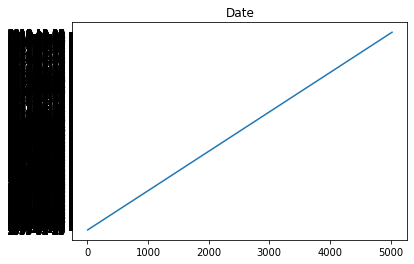

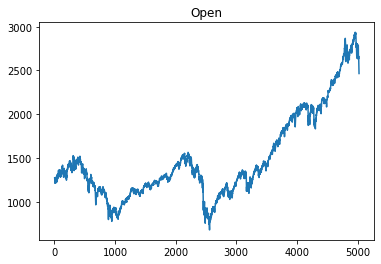

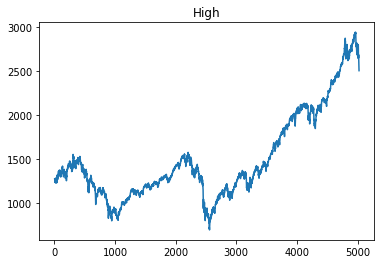

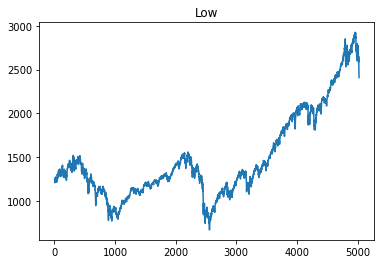

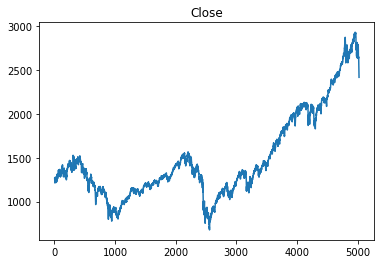

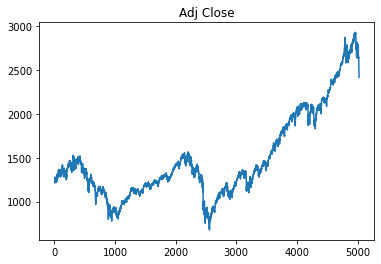

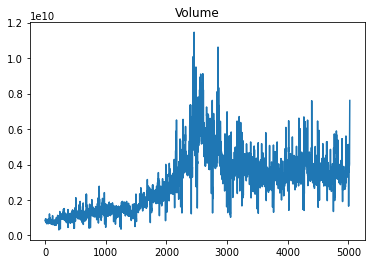

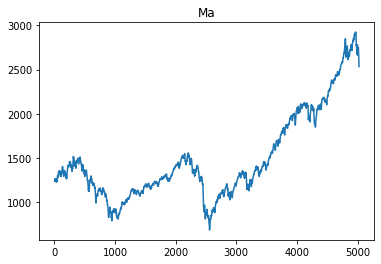

In [0]:
def plot_dataframe(dataframe):

  for column_name in dataframe.columns:
    plt.figure()
    plt.title(column_name)
    plt.plot(dataframe[column_name])

plot_dataframe(dataframe)

# Preprocessing

In [0]:
class Standarized_TimeseriesGenerator(tf.keras.preprocessing.sequence.TimeseriesGenerator):
  def __getitem__(self, index):
    samples, targets  = super(Standarized_TimeseriesGenerator, self).__getitem__(index)
    # shape : (n_batch, n_sequence, n_features)
    mean = samples.mean(axis=1)
    std = samples.std(axis=1)
    std[std==0] = 1
    samples = (samples - mean[:,None,:])/std[:,None,:] #standarize along each feature
    targets = (targets - mean[:,3:4])/std[:,3:4] # The close value is our target
    return samples, targets

In [0]:
# TimeseriesGenerator Check

data = np.array([[i, i**2,i**3,i**4] for i in range(11)])
targets = np.array([[i**4] for i in range(11)])

print(targets.shape)

mean = data[:-1].mean(axis=0)[None,:]
std = data[:-1].std(axis=0)[None,:]

data_gen = Standarized_TimeseriesGenerator(data, targets,
                               length=10, sampling_rate=1,
                               batch_size=2)
batch_0 = data_gen[0]
x, y = batch_0

print(np.array(x*std+mean,dtype = np.int))
print(y*std[..., 3]+mean[..., 3])

(11, 1)
[[[   0    0    0    0]
  [   1    1    1    1]
  [   2    4    8   16]
  [   3    9   27   81]
  [   4   16   64  256]
  [   5   25  125  625]
  [   6   36  216 1296]
  [   7   49  343 2401]
  [   8   64  512 4096]
  [   9   81  729 6561]]]
[[10000.]]


In [0]:
data.shape

(11, 4)

In [0]:
# Generarate 5 days sequences from all data
# TODO: How to deal with weekend lack of information?

n_sequence = 5
n_batch = 128
n_features = 7

def get_gen_train_test(dataframe):
  data = dataframe.drop(columns='Date').to_numpy()
  targets = data[:,3, None] #add none to have same number of dimensions as data
  #targets = data
  n_samples = data.shape[0]

  train_test_split=int(n_samples*0.9)

  data_gen_train = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = 0,
                                end_index = train_test_split,
                                shuffle = True)
  data_gen_test = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = train_test_split,
                                end_index = n_samples-1)
  
  return data_gen_train, data_gen_test

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

In [0]:
data_gen_train[0]

(array([[[ 1.6712912 ,  1.85502952,  1.61534934, ...,  1.72397052,
          -1.59549392,  1.21328069],
         [ 0.58792567, -0.24746246, -0.27151286, ..., -0.80766925,
           1.15901618,  0.87383526],
         [-0.63064956, -0.35605536, -0.32380062, ..., -0.74622125,
          -0.30943109,  0.12835121],
         [-1.07628987, -1.16784055, -1.42975807, ..., -0.71918757,
          -0.2341465 , -0.72449705],
         [-0.55227744, -0.08367114,  0.40972221, ...,  0.54910756,
           0.98005533, -1.49097012]],
 
        [[ 0.29243095,  0.17755632,  1.44553732, ...,  0.74748174,
          -0.6573422 ,  1.42632141],
         [ 0.61032243, -0.11837491, -0.84108527, ..., -1.26861896,
           0.0454765 ,  0.82377494],
         [-1.3995978 , -1.83692152, -1.36414084, ..., -0.72792507,
          -0.2898553 , -0.12137593],
         [-0.86056144,  0.88937043,  0.21620812, ...,  1.49686244,
           1.87831744, -1.12156449],
         [ 1.35740586,  0.88836969,  0.54348067, ..., -0.2478

In [0]:
# test on data

x_gen, y_gen = Standarized_TimeseriesGenerator(data, targets,
                               length=5, sampling_rate=1,
                               stride=1, batch_size=1)[0]
print(x_gen)
print(y_gen)

x = data[None, :5,:]
mean = x.mean(axis=1)
std = x.std(axis=1)
x = (x - mean)/std
y = (data[5,3] - mean[...,3])/std[...,3]
print(x)
print(y)

assert (x_gen == x).all()
assert y_gen == y

[[[-1.41421356 -1.01709526 -0.83189033 -0.72799757]
  [-0.70710678 -0.84757938 -0.79029581 -0.71771512]
  [ 0.         -0.33903175 -0.4991342  -0.56347834]
  [ 0.70710678  0.50854763  0.29116162  0.10488101]
  [ 1.41421356  1.69515876  1.83015873  1.90431003]]]
[[5.69853465]]
[[[-1.41421356 -1.01709526 -0.83189033 -0.72799757]
  [-0.70710678 -0.84757938 -0.79029581 -0.71771512]
  [ 0.         -0.33903175 -0.4991342  -0.56347834]
  [ 0.70710678  0.50854763  0.29116162  0.10488101]
  [ 1.41421356  1.69515876  1.83015873  1.90431003]]]
[5.69853465]


# Baseline 

In [0]:
# baseline: use previous day as estimation for the next
squared_error = 0
def mean_squared_error(X, lenght = 5):
  squared_error = 0
  for i in range(0, X.shape[0] - lenght):
    x = X[i:i+lenght]
    mean = x.mean()
    std = x.std()
    x = (x - mean)/std
    y = (X[i+lenght] - mean)/std
    squared_error += np.square(x[-1]-y)
  return squared_error/X.shape[0]

baseline_error = mean_squared_error(data[:,3])
baseline_error

3.4528189810500125

In [0]:
data_gen = Standarized_TimeseriesGenerator(data, targets,
                               length=5, sampling_rate=1,
                               stride=1, batch_size=32)

# baseline: use previous day as estimation for the next
def mean_squared_error(dataset):
  mse=0
  for X_batch, y_batch in dataset:
    # X_batch.shape : (n_batch, n_sequence, n_features)
    #mse += np.mean(np.square(X_batch[:, -1, 3:4]-y_batch))
    mse += np.mean(np.square(X_batch[:, -1, 3:4]-y_batch))
  mse /= len(dataset)
  return mse

baseline_error = mean_squared_error(data_gen)
baseline_error 

6.330168131925023

# Utilities

In [0]:
# Metrics not included in keras

# For some reason keras mape is different so it has to be customly defined.
# Paper definition isn't percentual, hence the difference. (x100)
def mse(y_true, y_pred):
  return tf.reduce_mean(tf.square(y_true-y_pred))
def mae(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true-y_pred)))
    # ***The absolute is over the whole thing as y_true can be negative
def mape(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true-y_pred)/y_true))
    # ***The absolute is over the whole thing as y_true can be negative
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true-y_pred)))
def ar(y_true, y_pred):
    mask = tf.cast(y_pred[1:] > y_true[:-1],tf.float32)
    return tf.reduce_mean((y_true[1:]-y_true[:-1])*mask)


#class ar(tf.keras.metrics.Metric):
#  def __init__(self, name="ar", **kwargs):
#    super(ar, self).__init__(name=name, **kwargs)
#    self.y_old = self.add_weight(name='y_old', shape=n_batch, initializer='zeros', dtype=tf.float32)
#    self.y_true = self.add_weight(name='y_true', shape=n_batch, initializer='zeros', dtype=tf.float32)
#    self.y_pred = self.add_weight(name='y_pred', shape=n_batch, initializer='zeros', dtype=tf.float32)

#  def update_state(self, y_true, y_pred, sample_weight = None):
#    self.y_true = y_true[:,3]
#    self.y_pred = y_pred[:,3]
#    # shape y : (batch_size, n_features)
#    self.y_old = tf.stack([self.y_old[-1] , self.y_true[:-1]], 0)

#  def result(self):
#    mask = tf.cast(self.y_pred > self.y_old, tf.float32)
#    return tf.reduce_mean((self.y_true - self.y_old)*mask)

   
  
  

In [0]:
# Metrics not included in keras

# For some reason keras mape is different so it has to be customly defined.
# Paper definition isn't percentual, hence the difference. (x100)
#def mape(y_true, y_pred):
#    return tf.keras.backend.mean(tf.keras.backend.abs((y_true-y_pred)/y_true))
#    # ***The absolute is over the whole thing as y_true can be negative

#def rmse(y_true, y_pred):
#    return tf.sqrt(tf.keras.backend.mean(tf.square(y_true-y_pred)))

#def ar(y_true, y_pred):
#    N = tf.cast(tf.size(y_true), tf.float32)
#    return tf.keras.backend.sum(tf.keras.backend.maximum(y_true-y_pred, 0)) / (N-1)

# ANN

In [0]:
def make_ANN_model():

  inputs = Input(shape=(n_sequence, n_features,))
  inputs_flatten = Flatten()(inputs)
  ann_1 = Dense(units=1000, activation=None)(inputs_flatten)
  batch_norm1=tf.keras.layers.BatchNormalization()(ann_1)
  ann_1_LRelu = LeakyReLU(alpha=0.3)(ann_1) 
  ann_1_droput = Dropout(0.3)(ann_1_LRelu)
  ann_2 = Dense(units=100, activation=None)(ann_1_droput)
  batch_norm2=tf.keras.layers.BatchNormalization()(ann_2)
  ann_2_LRelu = LeakyReLU(alpha=0.3)(ann_2) 
  ann_2_droput = Dropout(0.3)(ann_2_LRelu)
  output_dense = Dense(1, activation=None)(ann_2_droput)
  output = LeakyReLU(alpha=0.3)(output_dense) 


  model = Model(inputs = inputs, outputs = output)
  #model.compile(loss=generator_loss)
  model.compile(loss='mse', metrics = [mse , mae, mape, rmse, ar])
  #model.compile(loss=None, metrics = [mse , mae, mape, rmse])
  model.summary()

  #return model, slice_model
  return model

  #history = model.fit(data_gen_train, validation_data=data_gen_test, epochs = 100, 
   #                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))
  


In [0]:
#lstm = make_ANN_model()
#history = lstm.fit(data_gen_train, validation_data=data_gen_test, epochs = 100, 
#                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))

# Visualization

In [0]:
metrics = ["loss", 'mse','mae','mape','rmse','ar']
def plot_history(history):
  #metrics = ["loss", 'mse','mae','mape','rmse','ar']
  #metrics = ["gen_loss","gen_slice_loss", 'mse','mae','mape','rmae','ar']
  for metric_name in metrics:  
    plt.figure()
    plt.title(metric_name)
    plt.plot(history.history[metric_name], label='train')
    plt.plot(history.history["val_"+metric_name], label='test')
    plt.legend()
  plt.show()

#plot_history(history)

In [0]:
def plot_frame(sequence, target, model):
  sequence, target = data_gen_test[0]
  y_pred = model.predict(sequence)
  y_true = target

  plt.figure()
  plt.title("closing price")
  plt.plot(y_true, label="true")
  plt.plot(y_pred, label="prediction")
  plt.legend()
  plt.show()

#plot_frame(*data_gen_test[0], lstm)

# Test on all datasets

In [0]:
results = np.zeros((5,6))

## S&P500

stock_market_GAN/datasets/S&P500.csv
Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 5, 7)]            0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 35)                0         
_________________________________________________________________
dense_100 (Dense)            (None, 1000)              36000     
_________________________________________________________________
leaky_re_lu_100 (LeakyReLU)  (None, 1000)              0         
_________________________________________________________________
dropout_80 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_101 (Dense)            (None, 100)               100100    
_________________________________________________________________
leaky_re_lu_101 (Leak

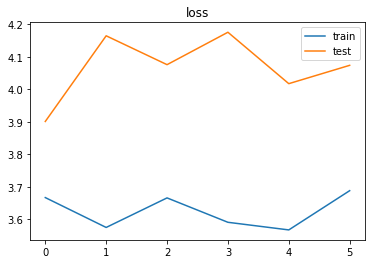

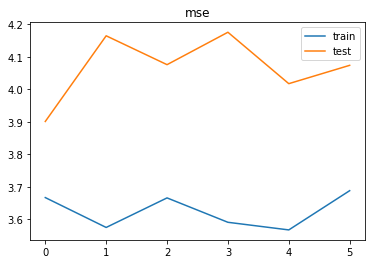

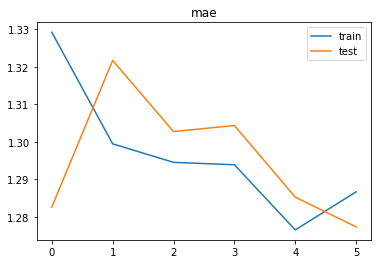

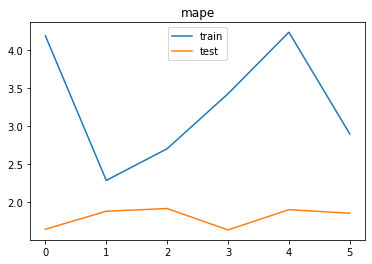

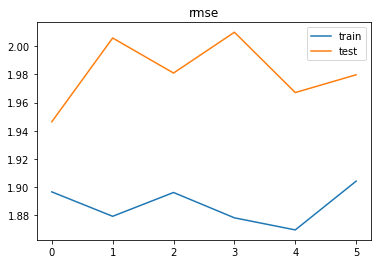

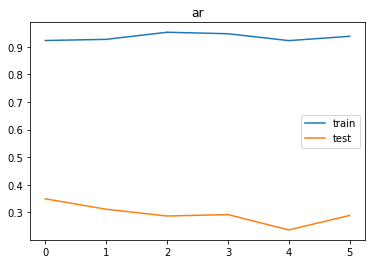

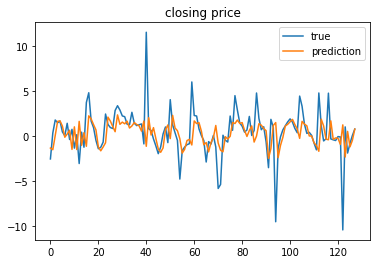

[MSE Baseline] train: 3.591598232052386  test: 3.8851370430342302
4/4 [==============================] - 0s 3ms/step - loss: 4.0737 - mse: 4.0737 - mae: 1.2774 - mape: 1.8523 - rmse: 1.9797 - ar: 0.2891


In [0]:
data_name = data_names[0]
data_path="stock_market_GAN/datasets/"+data_name+".csv"
print(data_path)
dataframe = pd.read_csv(data_path).dropna()

dataframe = add_Ma(dataframe)

#plot_dataframe(dataframe)

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

ann = make_ANN_model()
history = ann.fit(data_gen_train, validation_data=data_gen_test, epochs = 100,
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))
plot_history(history)
plot_frame(*data_gen_test[0], ann)

print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))

results[0] = ann.evaluate(data_gen_test)

## SSE

stock_market_GAN/datasets/SSE.csv
Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 5, 7)]            0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 35)                0         
_________________________________________________________________
dense_105 (Dense)            (None, 1000)              36000     
_________________________________________________________________
leaky_re_lu_105 (LeakyReLU)  (None, 1000)              0         
_________________________________________________________________
dropout_84 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_106 (Dense)            (None, 100)               100100    
_________________________________________________________________
leaky_re_lu_106 (LeakyRe

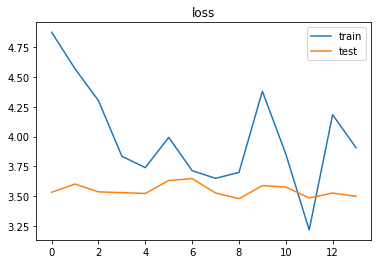

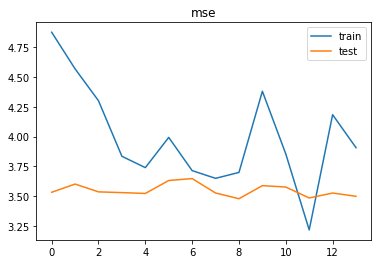

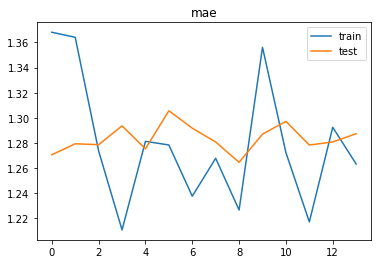

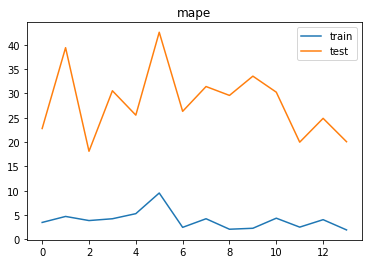

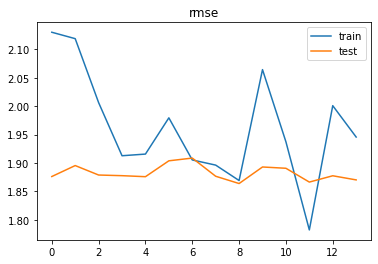

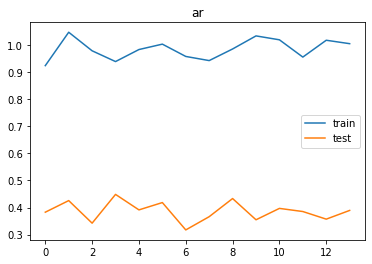

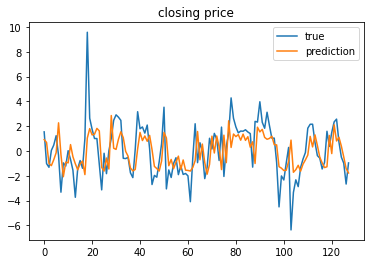

[MSE Baseline] train: 4.8402400500028895  test: 3.456689356602112
3/3 [==============================] - 0s 3ms/step - loss: 3.5002 - mse: 3.5002 - mae: 1.2874 - mape: 20.0809 - rmse: 1.8702 - ar: 0.3893


In [0]:
data_name = data_names[1]
data_path="stock_market_GAN/datasets/"+data_name+".csv"
print(data_path)

# we drop a couple of years because they have some periods were volume is zero
# we also drop some data which contain nans
dataframe = pd.read_csv(data_path)[1768:].dropna()

dataframe = add_Ma(dataframe)

#plot_dataframe(dataframe)

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

ann = make_ANN_model()
history = ann.fit(data_gen_train, validation_data=data_gen_test, epochs = 100, 
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))
plot_history(history)
plot_frame(*data_gen_test[0], ann)
print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
results[1] = ann.evaluate(data_gen_test)

## IBM

stock_market_GAN/datasets/IBM.csv
Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 5, 7)]            0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 35)                0         
_________________________________________________________________
dense_110 (Dense)            (None, 1000)              36000     
_________________________________________________________________
leaky_re_lu_110 (LeakyReLU)  (None, 1000)              0         
_________________________________________________________________
dropout_88 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_111 (Dense)            (None, 100)               100100    
_________________________________________________________________
leaky_re_lu_111 (LeakyRe

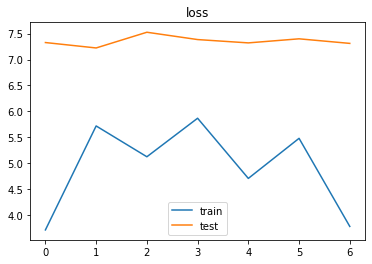

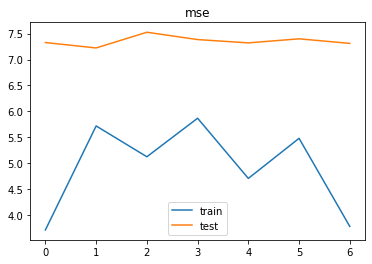

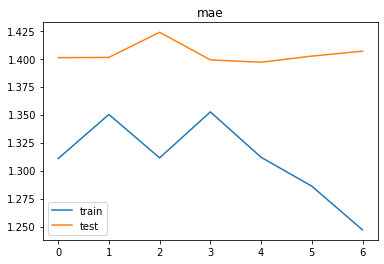

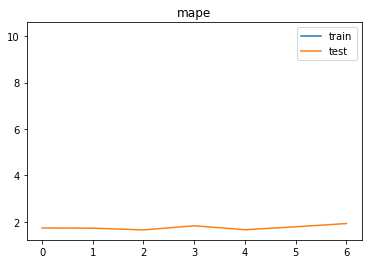

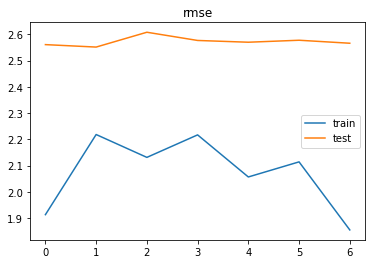

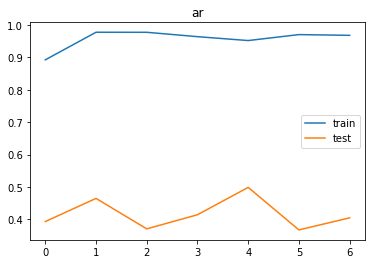

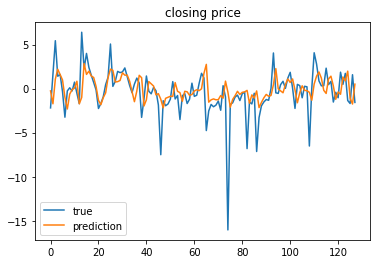

[MSE Baseline] train: 4.627927751202713  test: 7.163597671973363
4/4 [==============================] - 0s 3ms/step - loss: 7.3106 - mse: 7.3106 - mae: 1.4067 - mape: 1.9276 - rmse: 2.5659 - ar: 0.4046


In [0]:
data_name = data_names[2]
data_path="stock_market_GAN/datasets/"+data_name+".csv"
print(data_path)
dataframe = pd.read_csv(data_path).dropna()

dataframe = add_Ma(dataframe)

#plot_dataframe(dataframe)

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

ann = make_ANN_model()
history = ann.fit(data_gen_train, validation_data=data_gen_test, epochs = 100, 
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))
plot_history(history)
plot_frame(*data_gen_test[0], ann)

print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))

results[2] = ann.evaluate(data_gen_test)

## MSFT

stock_market_GAN/datasets/MSFT.csv
Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 5, 7)]            0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 35)                0         
_________________________________________________________________
dense_115 (Dense)            (None, 1000)              36000     
_________________________________________________________________
leaky_re_lu_115 (LeakyReLU)  (None, 1000)              0         
_________________________________________________________________
dropout_92 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_116 (Dense)            (None, 100)               100100    
_________________________________________________________________
leaky_re_lu_116 (LeakyR

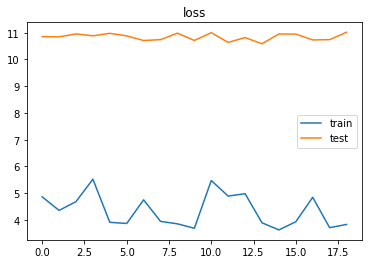

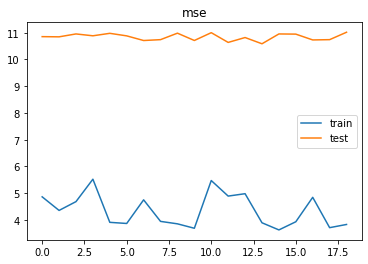

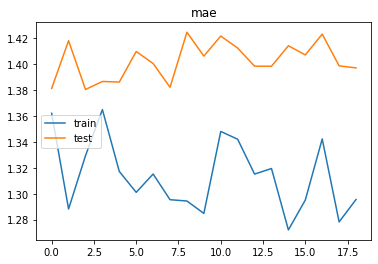

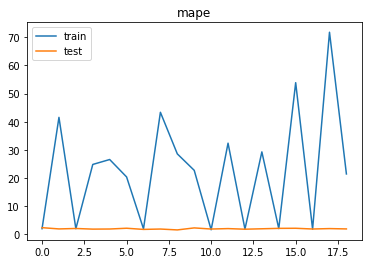

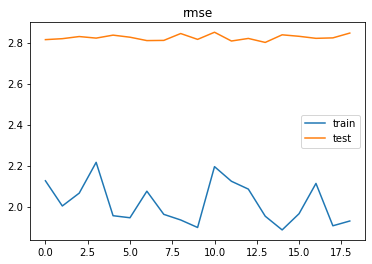

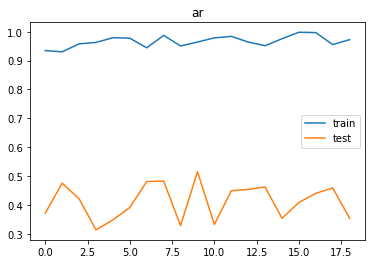

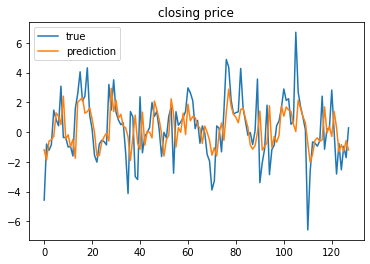

[MSE Baseline] train: 4.037076045396269  test: 10.919209093531334
4/4 [==============================] - 0s 3ms/step - loss: 11.0191 - mse: 11.0191 - mae: 1.3972 - mape: 1.8837 - rmse: 2.8461 - ar: 0.3540


In [0]:
data_name = data_names[3]
data_path="stock_market_GAN/datasets/"+data_name+".csv"
print(data_path)
dataframe = pd.read_csv(data_path).dropna()

dataframe = add_Ma(dataframe)

#plot_dataframe(dataframe)

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

ann = make_ANN_model()
history = ann.fit(data_gen_train, validation_data=data_gen_test, epochs = 100, 
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))
plot_history(history)
plot_frame(*data_gen_test[0], ann)

print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))

results[3] = ann.evaluate(data_gen_test)

## PAICC

stock_market_GAN/datasets/PAICC.csv
Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 5, 7)]            0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 35)                0         
_________________________________________________________________
dense_120 (Dense)            (None, 1000)              36000     
_________________________________________________________________
leaky_re_lu_120 (LeakyReLU)  (None, 1000)              0         
_________________________________________________________________
dropout_96 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_121 (Dense)            (None, 100)               100100    
_________________________________________________________________
leaky_re_lu_121 (Leaky

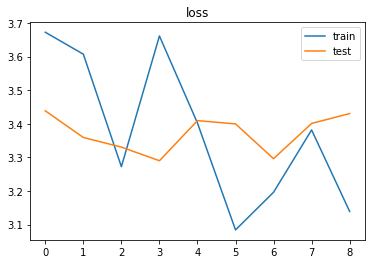

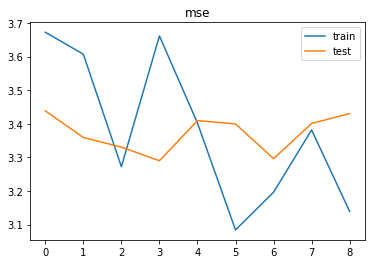

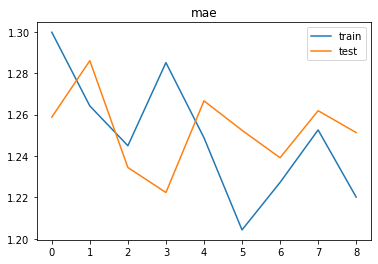

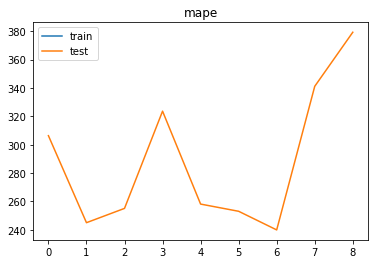

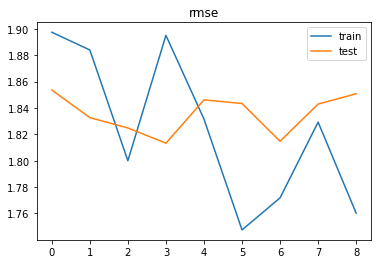

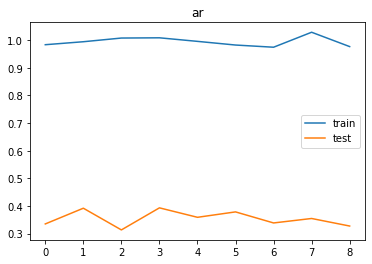

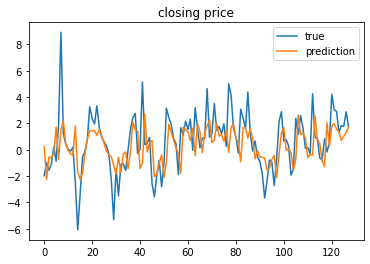

[MSE Baseline] train: 3.3561123865436993  test: 3.2622905110959155
3/3 [==============================] - 0s 3ms/step - loss: 3.4306 - mse: 3.4306 - mae: 1.2513 - mape: 379.2657 - rmse: 1.8508 - ar: 0.3273


In [0]:
data_name = data_names[4]
data_path="stock_market_GAN/datasets/"+data_name+".csv"
print(data_path)
dataframe = pd.read_csv(data_path).dropna()

dataframe = add_Ma(dataframe)

#plot_dataframe(dataframe)

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

ann = make_ANN_model()
history = ann.fit(data_gen_train, validation_data=data_gen_test, epochs = 100, 
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))
plot_history(history)
plot_frame(*data_gen_test[0], ann)

print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))

results[4] = ann.evaluate(data_gen_test)

## Results

In [0]:
df = pd.DataFrame(data = results, index = data_names, columns = metrics)
df.loc['mean'] = results.mean(axis=0)
df

,loss,mse,mae,mape,rmse,ar
S&P500,4.073749,4.073749,1.277371,1.852294,1.979694,0.289145
SSE,3.500156,3.500156,1.287399,20.080944,1.870232,0.389345
IBM,7.310606,7.310606,1.406703,1.927553,2.565921,0.404601
MSFT,11.019066,11.019066,1.397175,1.883669,2.846082,0.354021
PAICC,3.430578,3.430578,1.251322,379.265717,1.850762,0.327280
mean,5.866831,5.866831,1.323994,81.002035,2.222538,0.352878
